<a href="https://colab.research.google.com/github/Izzy55/STOCK-MARKET-PREDICTION/blob/master/AAPL_StockMarketPredictionNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json 
import os
import numpy as np
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler

TensorFlow 1.x selected.


/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [ ]:
api_key = '9CU08VA5IYTPJ0CH'

# ticker for stock market prices
ticker = "AAPL" 

# JSON file with all the stock market data for AAL within the last 20 years
url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)
print(url_string)
# Save data to this file
file_to_save = 'stock_market_data-%s.csv'%ticker

# If data not already saved,
# retrieve the data from the url
# And store date, low, high, volume, close, open values to a Pandas dataframe
if not os.path.exists(file_to_save):
  with urllib.request.urlopen(url_string) as url:
      data = json.loads(url.read().decode())
      # extract stock market data
      data = data['Time Series (Daily)']
      df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
      for k,v in data.items():
          date = dt.datetime.strptime(k, '%Y-%m-%d')
          data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                      float(v['4. close']),float(v['1. open'])]
          df.loc[-1,:] = data_row
          df.index = df.index + 1
  print('Data saved to : %s'%file_to_save)        
  df.to_csv(file_to_save)

# If the data is already there, load it from the CSV
else:
  print('File already exists. Loading data from CSV')
  df = pd.read_csv(file_to_save)



https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=AAPL&outputsize=full&apikey=9CU08VA5IYTPJ0CH
File already exists. Loading data from CSV


In [ ]:
# Sort DataFrame by date and print first 5 rows

df = df.sort_values('Date')

df.head()

,Unnamed: 0,Date,Low,High,Close,Open
5248,0,1999-11-01,77.37,80.69,77.62,80.00
5247,1,1999-11-02,77.31,81.69,80.25,78.00
5246,2,1999-11-03,81.00,83.25,81.50,81.62
5245,3,1999-11-04,80.62,85.37,83.62,82.06
5244,4,1999-11-05,84.00,88.37,88.31,84.62


In [ ]:
#Look at Shape

df.shape

(5249, 6)

In [ ]:
#General Summary

df.describe(include='all')

,Unnamed: 0,Date,Low,High,Close,Open
count,5249.000000,5249,5249.000000,5249.000000,5249.000000,5249.000000
unique,NaN,5249,NaN,NaN,NaN,NaN
top,NaN,2001-02-15,NaN,NaN,NaN,NaN
freq,NaN,1,NaN,NaN,NaN,NaN
mean,2624.000000,NaN,174.592558,178.655746,176.680097,176.693713
std,1515.400112,NaN,158.800792,161.665844,160.272039,160.340580
min,0.000000,NaN,12.720000,13.190000,13.120000,12.990000
25%,1312.000000,NaN,58.700000,61.200000,59.960000,59.850000
50%,2624.000000,NaN,121.600000,125.395100,123.660000,123.690000
75%,3936.000000,NaN,220.370000,225.370000,223.840000,223.640000


In [ ]:
#column summaries

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5249 entries, 5248 to 0
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5249 non-null   int64  
 1   Date        5249 non-null   object 
 2   Low         5249 non-null   float64
 3   High        5249 non-null   float64
 4   Close       5249 non-null   float64
 5   Open        5249 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 287.1+ KB


Text(0, 0.5, 'Mid Price')

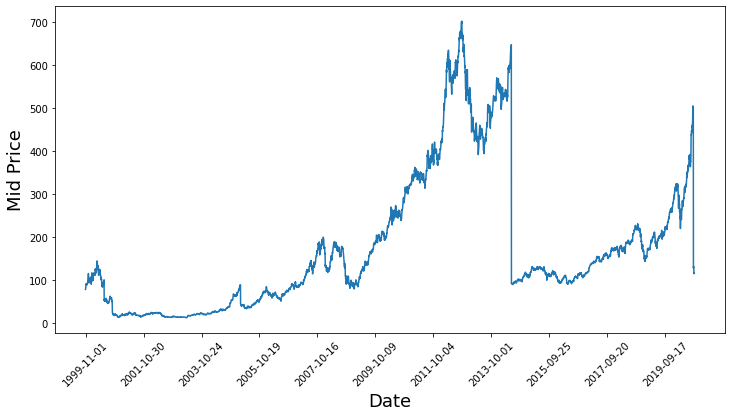

In [ ]:
#Plot Visualization

plt.figure(figsize = (12,6))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)

Now we have to devide the data into test and train set and standardize the data for training

In [ ]:
df.count()

Unnamed: 0    5249
Date          5249
Low           5249
High          5249
Close         5249
Open          5249
dtype: int64

In [ ]:
train_test_split_i = 4550
high_prices = df['High'].to_numpy()
low_prices = df['Low'].to_numpy()
mid_prices = (high_prices+low_prices)/2.0

In [ ]:
# Split data training vs testing
train_data = mid_prices[:train_test_split_i]
test_data = mid_prices[train_test_split_i:]

In [ ]:
# Normalize data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [ ]:
# Smoothing
smoothing_window_size = 900
for di in range(0, 4500, smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:]=scaler.transform(train_data[di:di+smoothing_window_size,:])
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [ ]:
# Reshape data
train_data = train_data.reshape(-1)

In [ ]:
# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [ ]:
# EMA
EMA = 0.0
gamma = 0.1
for ti in range(train_test_split_i):
    EMA = gamma*train_data[ti] + (1-gamma)*EMA
    train_data[ti] = EMA
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [ ]:
# Long Short-Term Memory models
class DataGeneratorSeq(object):
    def __init__(self, prices, batch_size, num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices)-num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length//self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]
         
    def next_batch(self):
        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)
         
        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)
            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b] = self._prices[self._cursor[b]+np.random.randint(0,5)]
            self._cursor[b] = (self._cursor[b]+1)%self._prices_length
        return batch_data, batch_labels
     
    def unroll_batches(self):
        unroll_data, unroll_labels = [], []
        init_data, init_label = None, None
        for ui in range(self._num_unroll):
            data, labels = self.next_batch()
            unroll_data.append(data)
            unroll_labels.append(labels)
        return unroll_data, unroll_labels
    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))

In [ ]:
dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

In [ ]:
for ui, (dat,lbl) in enumerate(zip(u_data,u_labels)):
    print('\nUnrolled index %d' %ui)
    print('\tInputs: ', dat)
    print('\tOutputs: ', lbl)


Unrolled index 0
	Inputs:  [0.04995651 0.01838971 0.16313984 0.06766853 0.781181  ]
	Outputs:  [0.17719448 0.02267178 0.12673196 0.06335865 0.7811992 ]

Unrolled index 1
	Inputs:  [0.09527287 0.01929546 0.14991714 0.06496208 0.7807593 ]
	Outputs:  [0.21484359 0.0235498  0.10742117 0.06496208 0.7820845 ]

Unrolled index 2
	Inputs:  [0.13804315 0.02050445 0.13790318 0.06335865 0.7811992 ]
	Outputs:  [0.2533078  0.02165918 0.10742117 0.06130918 0.7890829 ]

Unrolled index 3
	Inputs:  [0.17719448 0.02165918 0.12673196 0.06255794 0.7817948 ]
	Outputs:  [0.31723142 0.02267178 0.09899365 0.06166131 0.79584944]

Unrolled index 4
	Inputs:  [0.21484359 0.02267178 0.11684815 0.06145512 0.7820845 ]
	Outputs:  [0.34470424 0.02463674 0.11684815 0.06145512 0.79584944]


In [ ]:
D = 1 # Dimensionality of the data
num_unrollings = 50 # Number of time steps into the future
batch_size = 500 # Number of samples in a batch
num_nodes = [200, 200, 150] # Number of hidden nodes in each layer of the deep LSTM stack
n_layers = len(num_nodes) # Number of layers
dropout = 0.2 # Dropout amount

In [ ]:
# Reinitialize
tf.reset_default_graph()

In [ ]:
# Inputs
train_inputs = [tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui) for ui in range(num_unrollings)]
train_outputs = [tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui) for ui in range(num_unrollings)]

In [ ]:
# Set up the LSTM and Regression layers
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                           state_is_tuple=True,
                           initializer=tf.contrib.layers.xavier_initializer())
    for li in range(n_layers)]
 
drop_lstm_cells = [
    tf.contrib.rnn.DropoutWrapper(lstm, input_keep_prob=1.0,
                                 output_keep_prob=1.0-dropout,
                                 state_keep_prob=1.0-dropout)
    for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


In [ ]:
# LSTM layers
w = tf.get_variable('w',shape=[num_nodes[-1],1],
                   initializer=tf.contrib.layers.xavier_initializer())
# Linear regression layer
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))
 
# Cell state and hidden state
c = [tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False) for li in range(n_layers)]
h = [tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False) for li in range(n_layers)]
initial_state = [tf.contrib.rnn.LSTMStateTuple(c[li], h[li]) for li in range(n_layers)]

In [ ]:
# Formatting
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs], axis=0)
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major=True, dtype=tf.float32)
all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings, num_nodes[-1]])
 
all_outputs = tf.nn.xw_plus_b(all_lstm_outputs, w, b)
split_outputs = tf.split(all_outputs,num_unrollings, axis=0)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
# Training loss
# Mean Squared Error (MSE)
loss = 0.0
with tf.control_dependencies([tf.assign(c[li],state[li][0]) for li in range(n_layers)]+
                            [tf.assign(h[li],state[li][1]) for li in range(n_layers)]):
    loss += sum([tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2) for ui in range(num_unrollings)])
 
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step, global_step+1)
tf_learning_rate = tf.placeholder(shape=None, dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None, dtype=tf.float32)
 
learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate,global_step,
                               decay_steps=1, decay_rate=0.5,
                              staircase=True),
    tf_min_learning_rate)

In [ ]:
# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(zip(gradients,v))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# Defining prediction related TF calculations
sample_inputs = tf.placeholder(tf.float32, shape=[1,D])
sample_c = [tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False) for li in range(n_layers)]
sample_h = [tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False) for li in range(n_layers)]
initial_sample_state = [tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]) for li in range(n_layers)]
 
reset_sample_states = tf.group(*[[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)]+
                               [tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)]])
sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                                initial_state=tuple(initial_sample_state),
                                                time_major=True,
                                                dtype=tf.float32)
with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                            [tf.assign(sample_h[li], sample_state[li][1]) for li in range(n_layers)]):
    sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]),w,b)

In [ ]:
# Initialise before Running
epochs = 30
valid_summary = 1
n_predict_once = 50
train_seq_length = train_data.size
train_mse_ot = []
test_mse_ot = []
predictions_over_time = []
 
session = tf.InteractiveSession()
tf.global_variables_initializer().run()
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2
average_loss = 0
 
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings)
x_axis_seq = []
test_points_seq = np.arange(train_test_split_i,train_test_split_i+650,n_predict_once).tolist()

/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
for ep in range(epochs):
    # =================== Training =======================
    for step in range(train_seq_length//batch_size):
        u_data, u_labels = data_gen.unroll_batches()
        feed_dict = {}
        for ui, (dat,lbl) in enumerate(zip(u_data,u_labels)):
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)
        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
    # =================== Validation =======================
    if (ep+1) % valid_summary == 0:
        average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))
        if (ep+1)%valid_summary==0:
            print('Average loss at step %d: %f' %(ep+1, average_loss))
        train_mse_ot.append(average_loss)
        average_loss = 0
        predictions_seq, mse_test_loss_seq = [], []
    # =================== Update and make prediction =======================
    for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []
        if (ep+1)-valid_summary==0:
            x_axis=[]
        for tr_i in range(w_i-num_unrollings+1, w_i-1):
            current_price = all_mid_data[tr_i]
            feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)
            _ = session.run(sample_prediction, feed_dict=feed_dict)
         
        feed_dict = {}
        current_price = all_mid_data[w_i-1]
        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)
        for pred_i in range(n_predict_once):
            pred = session.run(sample_prediction, feed_dict=feed_dict)
            our_predictions.append(np.asscalar(pred))
            feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)
            if (ep+1)-valid_summary==0:
                x_axis.append(w_i+pred_i)
            mse_test_loss += 0.5 *(pred-all_mid_data[w_i+pred_i])**2
        session.run(reset_sample_states)
        predictions_seq.append(np.array(our_predictions))
        mse_test_loss/=n_predict_once
        mse_test_loss_seq.append(mse_test_loss)
        if (ep+1)-valid_summary==0:
            x_axis_seq.append(x_axis)
    current_test_mse = np.mean(mse_test_loss_seq)
     
    # learning rate decay logic
    if len(test_mse_ot)>0 and current_test_mse>min(test_mse_ot):
        loss_nondecrease_count += 1
    else:
        loss_nondecrease_count = 0
     
    if loss_nondecrease_count > loss_nondecrease_threshold:
        session.run(inc_gstep)
        loss_nondecrease_count = 0
        # Decreasing learning rate by 0.5
    test_mse_ot.append(current_test_mse)
    print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
    predictions_over_time.append(predictions_seq)
    print('\tFinished Predictions') 

Average loss at step 1: 2.308585


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


	Test MSE: 4.24302
	Finished Predictions
Average loss at step 2: 0.634373
	Test MSE: 1.90196
	Finished Predictions
Average loss at step 3: 0.487020
	Test MSE: 3.14520
	Finished Predictions
Average loss at step 4: 0.288713
	Test MSE: 2.11614
	Finished Predictions
Average loss at step 5: 0.217057
	Test MSE: 2.39042
	Finished Predictions
Average loss at step 6: 0.171101
	Test MSE: 1.93265
	Finished Predictions
Average loss at step 7: 0.158114
	Test MSE: 2.14413
	Finished Predictions
Average loss at step 8: 0.144651
	Test MSE: 1.98789
	Finished Predictions
Average loss at step 9: 0.135325
	Test MSE: 2.10030
	Finished Predictions
Average loss at step 10: 0.125916
	Test MSE: 2.11548
	Finished Predictions
Average loss at step 11: 0.126602
	Test MSE: 2.10237
	Finished Predictions
Average loss at step 12: 0.132383
	Test MSE: 2.20434
	Finished Predictions
Average loss at step 13: 0.133703
	Test MSE: 2.25083
	Finished Predictions
Average loss at step 14: 0.135475
	Test MSE: 2.30443
	Finished Pred

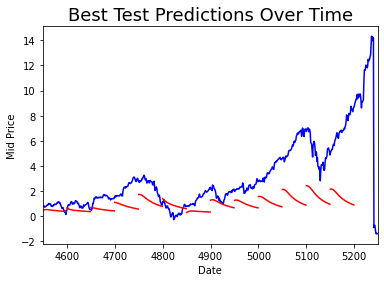

In [ ]:
# Plot
 
best_prediction_epoch = 2
 
plt.plot(range(df.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')
plt.title('Best Test Predictions Over Time', fontsize=18)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Mid Price',fontsize=10)
plt.xlim(train_test_split_i,len(df))
plt.show()

## Decision Tree Regression Model and Linear Regression Model

In [ ]:
# Import necessary models from sklearn

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
# re-look at the initial data

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5249 entries, 5248 to 0
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5249 non-null   int64  
 1   Date        5249 non-null   object 
 2   Low         5249 non-null   float64
 3   High        5249 non-null   float64
 4   Close       5249 non-null   float64
 5   Open        5249 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 287.1+ KB
None
      Unnamed: 0        Date    Low   High  Close   Open
5248           0  1999-11-01  77.37  80.69  77.62  80.00
5247           1  1999-11-02  77.31  81.69  80.25  78.00
5246           2  1999-11-03  81.00  83.25  81.50  81.62
5245           3  1999-11-04  80.62  85.37  83.62  82.06
5244           4  1999-11-05  84.00  88.37  88.31  84.62


In [ ]:
# number of rows = number of trading days

print(df.shape)

(5249, 6)


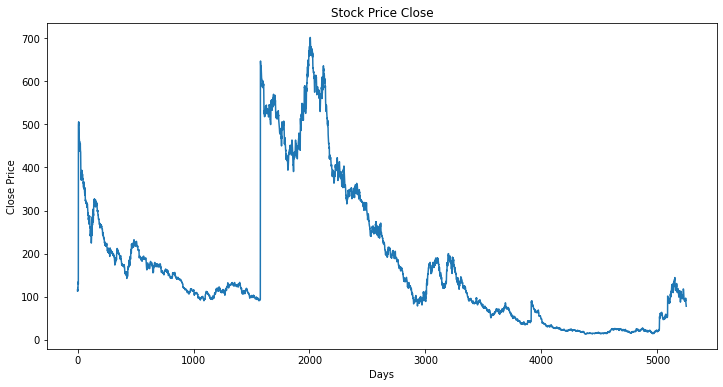

In [ ]:
# Prediction to be made on close price data
# Visualisation of close price

plt.figure(figsize=(12,6))
plt.title('Stock Price Close')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.plot(df['Close'])
plt.show()

In [ ]:
# Create close price only dataframe

close_df = df[['Close']]
print(close_df.head())

      Close
5248  77.62
5247  80.25
5246  81.50
5245  83.62
5244  88.31


In [ ]:
# Define Variables

days_to_future = 30    # Days into future model will predict into

# Add target column to close_df with data for price shifted 'days_to_future' ahead
close_df['Prediction'] = df[['Close']].shift(-days_to_future)
print(close_df.head())

      Close  Prediction
5248  77.62       94.87
5247  80.25       97.00
5246  81.50       98.31
5245  83.62      100.00
5244  88.31       98.00


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Verify predictions for end of dataframe are NaN
print(close_df.tail())

    Close  Prediction
4  120.88         NaN
3  120.96         NaN
2  112.82         NaN
1  117.32         NaN
0  113.49         NaN


In [ ]:
# Create feature dataset 'X'
# Leave off last 'days_to_future' rows

X = np.array(close_df.drop(['Prediction'], 1))[:-days_to_future]
print(X[:10])
print(X.shape)

[[77.62]
 [80.25]
 [81.5 ]
 [83.62]
 [88.31]
 [96.37]
 [89.62]
 [91.44]
 [92.25]
 [90.62]]
(5219, 1)


In [ ]:
# Create target dataset 'y'
# Leave off last 'days_to_future' rows

y = np.array(close_df.drop(['Close'], 1))[:-days_to_future]
print(y[:10])
print(y.shape)

[[ 94.87]
 [ 97.  ]
 [ 98.31]
 [100.  ]
 [ 98.  ]
 [102.5 ]
 [ 99.94]
 [103.5 ]
 [ 99.31]
 [ 98.19]]
(5219, 1)


In [ ]:
# Split data into 20% test and 80% train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [ ]:
# Create Decision Tree Regressor model

tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)
tree_pred = tree_model.predict(X_test)
tree_mse = mean_squared_error(y_test, tree_pred)
print(tree_mse)

2970.6857593684304


In [ ]:
# Create Linear Regression model

linear = LinearRegression()
linear.fit(X_train, y_train)
linear_pred = linear.predict(X_test)
linear_mse = mean_squared_error(y_test, linear_pred)
print(linear_mse)

2325.980792249422


In [ ]:
future_days = close_df.drop(['Prediction'], 1)[:-days_to_future]
future_days = future_days.tail(days_to_future)
future_days = np.array(future_days)
print(future_days)

[[351.59]
 [351.73]
 [349.72]
 [358.87]
 [366.53]
 [360.06]
 [364.84]
 [353.63]
 [361.78]
 [364.8 ]
 [364.11]
 [364.11]
 [373.85]
 [372.69]
 [381.37]
 [383.01]
 [383.68]
 [381.91]
 [388.23]
 [390.9 ]
 [386.09]
 [385.31]
 [393.43]
 [388.  ]
 [389.09]
 [371.38]
 [370.46]
 [379.24]
 [373.01]
 [380.16]]


In [ ]:
# Predict with Decision Tree Model
tree_predict = tree_model.predict(future_days)
print(tree_predict)

[384.76   425.04   435.75   438.66   440.25   327.46   383.58   450.91
 348.5075 383.58   459.835  459.835  369.8    462.25   462.83   473.1
 388.81   419.81   499.3    420.3    500.04   499.23   129.04   424.7
 279.4045 120.88   120.96   112.82   117.32   113.49  ]


In [ ]:
# Preduct with Linear Regression Model

linear_predict = linear.predict(future_days)
print(linear_predict)

[[346.17101498]
 [346.30545246]
 [344.37531434]
 [353.161764  ]
 [360.51741475]
 [354.30448259]
 [358.8945623 ]
 [348.12996113]
 [355.95614307]
 [358.85615159]
 [358.19356686]
 [358.19356686]
 [367.54657447]
 [366.43266391]
 [374.76778774]
 [376.3426268 ]
 [376.98600618]
 [375.28633231]
 [381.35522431]
 [383.91913913]
 [379.30025138]
 [378.55124256]
 [386.34861646]
 [381.13436273]
 [382.18105455]
 [365.1747132 ]
 [364.29126689]
 [372.72241749]
 [366.73994958]
 [373.60586379]]


In [ ]:
# Future Prediction MSE, linear and decision tree

future_tree_mse = mean_squared_error(future_days, tree_predict)
future_linear_mse = mean_squared_error(future_days, linear_predict)

print('30 Day Tree Future Prediction MSE: ', future_tree_mse)
print('30 Day Linear Future Prediction MSE: ', future_linear_mse)

30 Day Tree Future Prediction MSE:  17819.172740550002
30 Day Linear Future Prediction MSE:  39.45951669073987


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


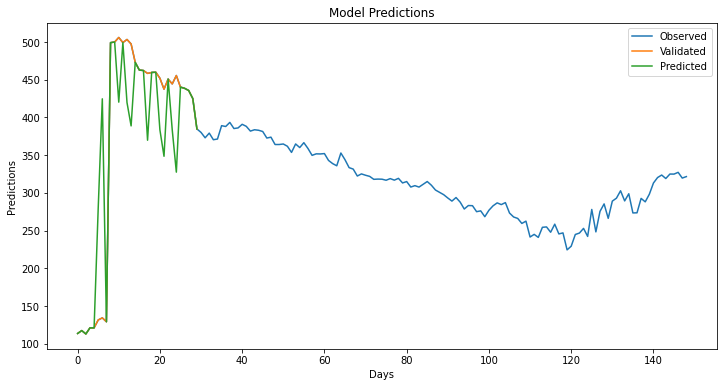

In [ ]:
# Visualization of results

predictions = tree_predict

validation = close_df[X.shape[0]:]
validation['Predictions'] = predictions

plt.figure(figsize=(12,6))
plt.title('Model Predictions')
plt.xlabel('Days')
plt.ylabel('Predictions')
plt.plot(close_df['Close'].iloc[5100:])
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Observed', 'Validated', 'Predicted'])
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


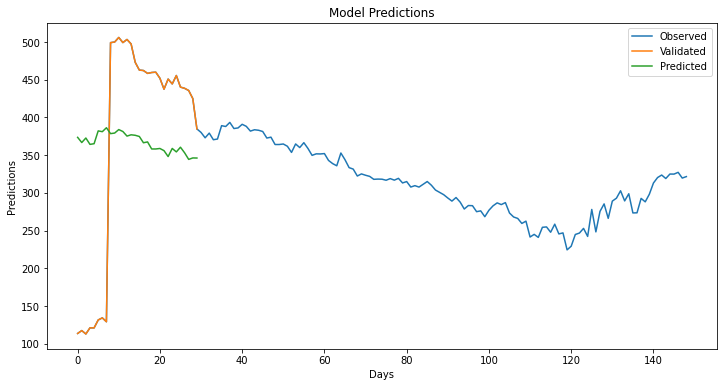

In [ ]:
# Visualize Linear Model Results

lpredictions = linear_predict

validation = close_df[X.shape[0]:]
validation['Predictions'] = lpredictions

plt.figure(figsize=(12,6))
plt.title('Model Predictions')
plt.xlabel('Days')
plt.ylabel('Predictions')
plt.plot(close_df['Close'].iloc[5100:])
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Observed', 'Validated', 'Predicted'])
plt.show()

## XG Boost Model

In [ ]:
import xgboost as xgb

# Convert the training and testing sets into DMatrixes: DM_train, DM_test
DM_train = xgb.DMatrix(data=X_train, label=y_train)
DM_test =  xgb.DMatrix(data=X_test, label=y_test)


# Create the parameter dictionary: params
params = {"objective":"reg:squarederror"}

# Train the model: xg_reg
xg_reg = xgb.train(params = params, dtrain=DM_train, num_boost_round=5)

# Predict the labels of the test set: preds
preds = xg_reg.predict(DM_test)

# Compute and print the RMSE
xgb_mse = mean_squared_error(X_test,preds)
print("MSE: %f" % (xgb_mse))

MSE: 2075.320157


In [ ]:
# Cross Validation with XGBoost

# Create the DMatrix: xgb_dmatrix
xgb_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":4}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=xgb_dmatrix, params=params, nfold=4, num_boost_round=5, metrics='rmse', as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Extract and print final boosting round metric
print((cv_results["test-rmse-mean"]).tail(1))

   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0       170.448429        1.032406      170.518906       3.602331
1       123.595009        0.643585      123.853552       2.573095
2        92.054792        0.427136       92.309601       1.886896
3        71.190990        0.389426       71.847767       1.254815
4        57.747428        0.450903       58.901878       1.352387
4    58.901878
Name: test-rmse-mean, dtype: float64


In [ ]:
# Hyperparameter tuning using RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV

# Create the parameter grid: gbm_param_grid 
gbm_param_grid = {
    'colsample_bytree': np.arange(0.2, 0.7, 0.1),
    'learning_rate': np.arange(0.04, 1, 0.02),
    'max_depth': np.arange(3, 10, 1),
    'n_estimators': np.arange(50, 200, 50)

}

# Instantiate the regressor: gbm
rs_gbm = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=10)

# Perform random search: grid_mse
randomized_mse = RandomizedSearchCV(param_distributions=gbm_param_grid, estimator=rs_gbm, scoring="neg_mean_squared_error", verbose=1, n_iter=5, cv=4)


# Fit randomized_mse to the data
randomized_mse.fit(X,y)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters found:  {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.27999999999999997, 'colsample_bytree': 0.2}
Lowest RMSE found:  140.45734399622464


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.3s finished


In [ ]:
# Create the parameter dictionary: params
best_params = {"objective":"reg:squarederror", 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.31999999999999995, 'colsample_bytree': 0.2 }

# Train the model: xg_reg
best_xg_reg = xgb.train(params = params, dtrain=DM_train, num_boost_round=5)

# Predict the labels of the test set: preds
best_preds = best_xg_reg.predict(DM_test)

# Compute and print the RMSE
best_xgb_mse = mean_squared_error(X_test,best_preds)
print("RMSE: %f" % (best_xgb_mse))

RMSE: 2143.250960


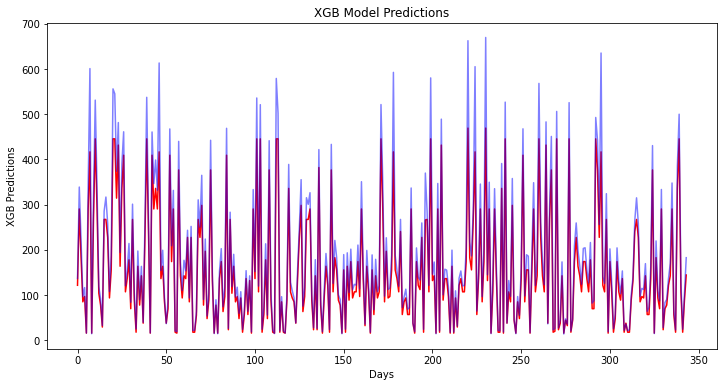

In [ ]:
# Plot Best XGB Prediction for the final 43 days
plt.figure(figsize=(12,6))
plt.title('XGB Model Predictions')
plt.xlabel('Days')
plt.ylabel('XGB Predictions')
plt.plot(best_preds[700:], c='red')
plt.plot(X_test[700:], c='blue', alpha = 0.5)
plt.show()

## One step ahead prediction using Standard Averaging technique

In [ ]:
# One step ahead prediction using Standard Averaging technique

# Define initial values and create empty arrays

window_size = 50
N = train_data.size


std_avg_predictions = []
std_avg_date = []
std_mse_errors = []

# Generate Predictions and append predictions, dates, and errors to correct arrays

for idx in range(window_size, N):

  if idx >= N:
    date = dt.datetime.strptime(k, '%Y-%m-%d').date + dt.timedelta(days=1)
  else:
    date = df.loc[idx, 'Date']

  std_avg_predictions.append(np.mean(train_data[idx-window_size:idx]))
  std_mse_errors.append((std_avg_predictions[-1]-train_data[idx])**2)
  std_avg_date.append(date)  


# Print resulting MSE for Standard Averaging
print('Standard Average MSE error: %.5f'%(0.5*np.mean(std_mse_errors)))

Standard Average MSE error: 0.00614


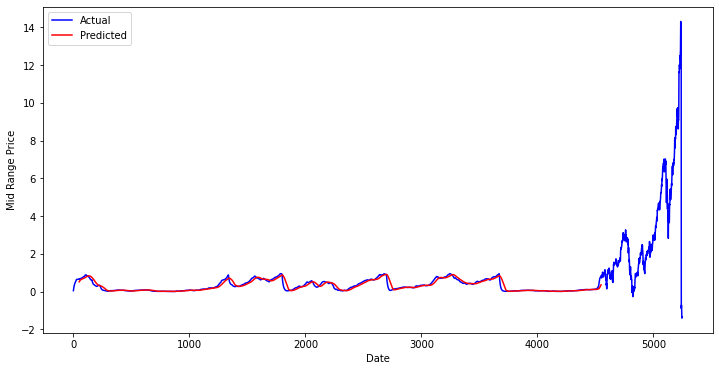

In [ ]:
# Visualize Standard Average Preduction and Actual Value on overlayed plot

plt.figure(figsize=(12,6))
plt.plot(range(df.shape[0]), all_mid_data, color='blue', label='Actual')
plt.plot(range(window_size,N), std_avg_predictions, color = 'red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Mid Range Price')
plt.legend()
plt.show()

## One step ahead prediction using the Exponential Moving Average

In [ ]:
# One step ahead prediction using the Exponential Moving Average

# Define initial values and create empty arrays 

window_size = 50
N = train_data.size

run_avg_predictions = []
run_avg_dates = []
run_mse_errors = []

running_mean = 0.0     # exponential moving average
decay = 0.5            # gamma

run_avg_predictions.append(running_mean)

# Generate Predictions and append predictions, dates, and errors to correct arrays

for ema_idx in range(1,N):
  running_mean = running_mean*decay + (1-decay)*train_data[ema_idx-1]
  run_avg_predictions.append(running_mean)
  run_mse_errors.append((run_avg_predictions[-1]-train_data[ema_idx])**2)
  run_avg_dates.append(date)


# Print resulting MSE for Standard Averaging
print('Standard Average MSE error: %.5f'%(0.5*np.mean(run_mse_errors)))  

Standard Average MSE error: 0.00010


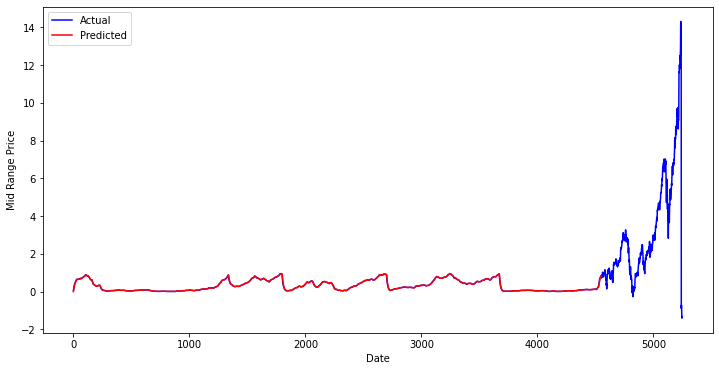

In [ ]:
# Visualize Exponential Moving Average Preduction and Actual Value on overlayed plot

plt.figure(figsize=(12,6))
plt.plot(range(df.shape[0]), all_mid_data, color='blue', label='Actual')
plt.plot(range(0,N), run_avg_predictions, color = 'red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Mid Range Price')
plt.legend()
plt.show()

## Part Two:
## Prediction Accuracy Improvement with Hyperparameter Tuning of Simple Models

In [ ]:
# Ridge Regression

from sklearn import linear_model
ridge = linear_model.Ridge(alpha=.5)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_pred)
print(ridge_mse)


2325.9807920446265


In [ ]:
# Cross Validated RidgeCV

ridge_cv = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13), cv=10)
ridge_cv.fit(X_train, y_train)
ridge_cv_pred = ridge_cv.predict(X_test)
ridge_cv_mse = mean_squared_error(y_test, ridge_cv_pred)
print(ridge_cv_mse)
print(ridge_cv.alpha_)


2325.9604827036796
100000.0


In [ ]:
# Future Predict with Ridge Model
ridge_predict = ridge.predict(future_days)
print(ridge_predict)

[[346.17101418]
 [346.30545166]
 [344.37531355]
 [353.16176316]
 [360.51741388]
 [354.30448175]
 [358.89456144]
 [348.12996032]
 [355.95614222]
 [358.85615073]
 [358.193566  ]
 [358.193566  ]
 [367.54657357]
 [366.43266302]
 [374.7677868 ]
 [376.34262586]
 [376.98600523]
 [375.28633137]
 [381.35522334]
 [383.91913815]
 [379.30025043]
 [378.55124161]
 [386.34861547]
 [381.13436177]
 [382.18105358]
 [365.17471231]
 [364.29126601]
 [372.72241656]
 [366.73994869]
 [373.60586286]]


In [ ]:
# Future Predict with Ridge CV Model
ridge_cv_predict = ridge_cv.predict(future_days)
print(ridge_cv_predict)

[[346.01105631]
 [346.14536766]
 [344.21704052]
 [352.99524614]
 [360.34399533]
 [354.13689256]
 [358.72266555]
 [347.96816445]
 [355.78700334]
 [358.68429088]
 [358.02232783]
 [358.02232783]
 [367.36655983]
 [366.25369442]
 [374.58099768]
 [376.15435912]
 [376.79713483]
 [375.09905571]
 [381.16225348]
 [383.72376266]
 [379.10920867]
 [378.36090261]
 [386.1509605 ]
 [380.94159913]
 [381.98730887]
 [364.996924  ]
 [364.1143066 ]
 [372.53754653]
 [366.56069177]
 [373.42016393]]


In [ ]:
# Future Prediction MSE, Ridge and Ridge CV

future_ridge_mse = mean_squared_error(future_days, ridge_predict)
future_ridgecv_mse = mean_squared_error(future_days, ridge_cv_predict)

print('30 Day Ridge Regression Prediction MSE: ', future_ridge_mse)
print('30 Day Cross Validated Ridge Regression Prediction MSE: ', future_ridgecv_mse)

30 Day Ridge Regression Prediction MSE:  39.45952797068527
30 Day Cross Validated Ridge Regression Prediction MSE:  41.74558204231466


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


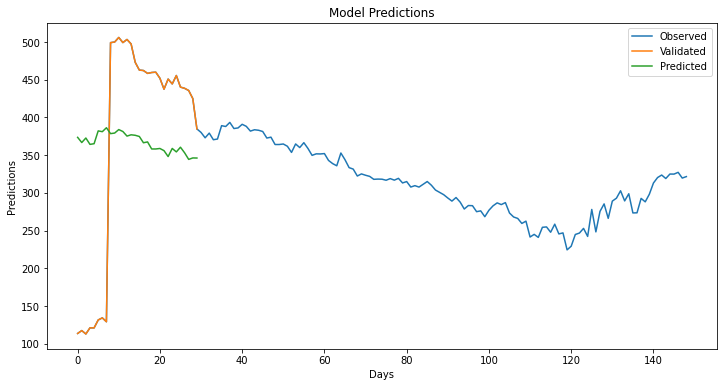

In [ ]:
# Visualize Ridge Model Results

rpredictions = ridge_predict

validation = close_df[X.shape[0]:]
validation['Predictions'] = rpredictions

plt.figure(figsize=(12,6))
plt.title('Model Predictions')
plt.xlabel('Days')
plt.ylabel('Predictions')
plt.plot(close_df['Close'].iloc[5100:])
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Observed', 'Validated', 'Predicted'])
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


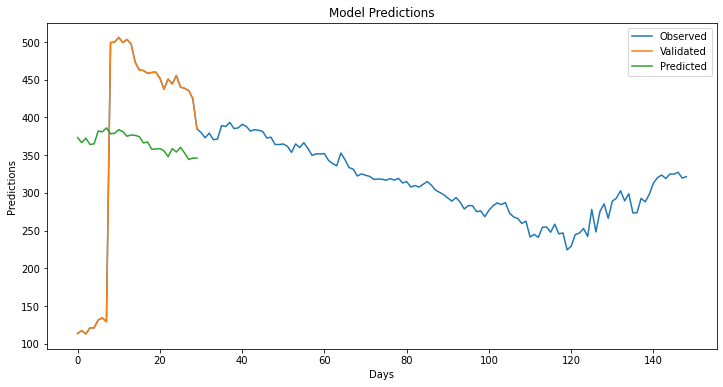

In [ ]:
# Visualize Cross Validated Ridge Model Results

rcvpredictions = ridge_cv_predict

validation = close_df[X.shape[0]:]
validation['Predictions'] = rcvpredictions

plt.figure(figsize=(12,6))
plt.title('Model Predictions')
plt.xlabel('Days')
plt.ylabel('Predictions')
plt.plot(close_df['Close'].iloc[5100:])
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Observed', 'Validated', 'Predicted'])
plt.show()

In [ ]:
# Lasso

clf = linear_model.Lasso(alpha=0.1)
clf.fit(X_train, y_train)
clf_pred = clf.predict(X_test)
clf_mse = mean_squared_error(y_test, clf_pred)
print(clf_mse)

2325.980614559886


In [ ]:
# Future Predict with Lasso Model

clf_predict = clf.predict(future_days)
print(clf_predict)

[346.17031887 346.3047558  344.37462556 353.16103934 360.51666005
 354.30375326 358.89381423 348.12925702 355.955407   358.85540368
 358.19282166 358.19282166 367.54579108 366.43188507 374.76697486
 376.34180749 376.98518424 375.28551731 381.35438453 383.91828888
 379.29942    378.55041423 386.3477563  381.13352386 382.1802114
 365.17393949 364.29049679 372.72161296 366.73916948 373.60505566]


In [ ]:
# Future Prediction MSE for Lasso

future_clf_mse = mean_squared_error(future_days, clf_predict)

print('30 Day Lasso Future Prediction MSE: ', future_clf_mse)


30 Day Lasso Future Prediction MSE:  39.469325765521255


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


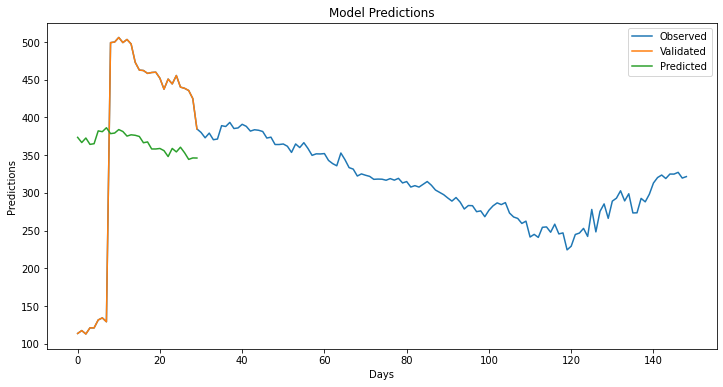

In [ ]:
# Visualize Lasso Model Results

clfpredictions = clf_predict

validation = close_df[X.shape[0]:]
validation['Predictions'] = clfpredictions

plt.figure(figsize=(12,6))
plt.title('Model Predictions')
plt.xlabel('Days')
plt.ylabel('Predictions')
plt.plot(close_df['Close'].iloc[5100:])
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Observed', 'Validated', 'Predicted'])
plt.show()

In [ ]:
# Decision Tree Regression with Randomized Hyperparameter Search

# Create the parameter grid
param_grid = {'max_depth': list(range(2,10)), 
              'max_features': ['auto' , 'sqrt'],
              'criterion' : ['mse', 'mae'],
              'splitter':['best', 'random'],
              'min_samples_leaf': list(range(5,20))
              } 

# Create a random search object
tree_rs = RandomizedSearchCV(
    estimator = DecisionTreeRegressor(),
    param_distributions = param_grid, n_iter = 10,
    scoring='neg_mean_squared_error', cv = 5, refit=True, return_train_score =True, verbose=1 )

# Fit to the training data
tree_rs.fit(X_train, y_train)

# Print the values used for both hyperparameters
print(tree_rs.cv_results_['param_max_depth'])
print(tree_rs.cv_results_['param_max_features'])
print(tree_rs.cv_results_['param_criterion'])
print(tree_rs.cv_results_['param_splitter'])
print(tree_rs.cv_results_['param_min_samples_leaf'])

# Print the best parameters and lowest RMSE
print("Best parameters found: ", tree_rs.best_params_)
print("Lowest RMSE found: ", np.abs(tree_rs.best_score_))


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[8 6 9 8 9 7 2 5 7 8]
['sqrt' 'auto' 'auto' 'sqrt' 'auto' 'auto' 'auto' 'auto' 'auto' 'sqrt']
['mae' 'mse' 'mse' 'mse' 'mse' 'mae' 'mae' 'mae' 'mse' 'mae']
['random' 'random' 'best' 'best' 'random' 'best' 'best' 'best' 'random'
 'best']
[18 11 12 10 7 6 5 5 12 16]
Best parameters found:  {'splitter': 'best', 'min_samples_leaf': 12, 'max_features': 'auto', 'max_depth': 9, 'criterion': 'mse'}
Lowest RMSE found:  1931.2199288390962


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.0s finished


In [ ]:
#Create new Decision Tree model using best parameters

# Create the parameter dictionary: params
best_rs_params = {'splitter':'best', 'min_samples_leaf': 10, 'max_features': 'auto', 'max_depth': 5, 'criterion': 'mse'}

# Train the model: xg_reg
best_tree_rs = DecisionTreeRegressor(splitter='best', min_samples_leaf=10, max_features='auto', max_depth=5, criterion='mse')
best_tree_rs.fit(X_train, y_train)

# Predict the labels of the test set: preds
tree_rs_preds = best_tree_rs.predict(X_test)

# Compute and print the MSE
best_treers_mse = mean_squared_error(X_test,tree_rs_preds)
print("MSE: %f" % (best_treers_mse))

MSE: 523.117335


In [ ]:
# Future Prediction with Best Decision Tree Model

future_tree_rs = best_tree_rs.predict(future_days)
print(future_tree_rs)

[366.02961207 366.02961207 349.67520455 366.02961207 366.02961207
 366.02961207 366.02961207 366.02961207 366.02961207 366.02961207
 366.02961207 366.02961207 366.02961207 366.02961207 429.11380952
 429.11380952 429.11380952 429.11380952 429.11380952 394.31713514
 429.11380952 429.11380952 394.31713514 429.11380952 394.31713514
 366.02961207 366.02961207 366.02961207 366.02961207 366.02961207]


In [ ]:
# Future Prediction MSE for Best Decision Tree Model

future_treers_mse = mean_squared_error(future_days, future_tree_rs)

print('30 Day Best Tree Future Prediction MSE: ', future_treers_mse)

30 Day Best Tree Future Prediction MSE:  570.9273987088787


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


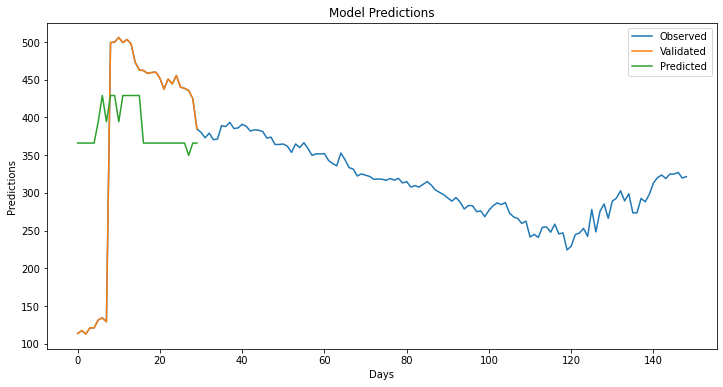

In [ ]:
# Visualize Best Tree Model Results

treerspredictions = future_tree_rs

validation = close_df[X.shape[0]:]
validation['Predictions'] = treerspredictions

plt.figure(figsize=(12,6))
plt.title('Model Predictions')
plt.xlabel('Days')
plt.ylabel('Predictions')
plt.plot(close_df['Close'].iloc[5100:])
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Observed', 'Validated', 'Predicted'])
plt.show()

Referrences:

https://www.programmersought.com/article/5487636739/

https://wingkiwong.wordpress.com/2019/01/13/long-short-term-memory-in-time-series-data/

https://towardsdatascience.com/using-lstms-for-stock-market-predictions-tensorflow-9e83999d4653

https://www.thepythoncode.com/article/stock-price-prediction-in-python-using-tensorflow-2-and-keras

https://analyticsindiamag.com/hands-on-guide-to-lstm-recurrent-neural-network-for-stock-market-prediction/

https://blog.usejournal.com/stock-market-prediction-by-recurrent-neural-network-on-lstm-model-56de700bff68

https://github.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction

http://colah.github.io/posts/2015-08-Understanding-LSTMs/

